# Computing momentum budget in SUSTAIN

In this notebook, we'll combine multiple measurements to close the momentum budget in SUSTAIN.
Momentum budget allows us to estimate surface stress from along-tank mean slope, radiation stress,
and along-tank static pressure gradient.
This is useful in high wind speeds where spray can pollute the sonic anemometer measurement. 

From the momentum balance for water in the tank, assuming small nonlinear terms and steady state, we get:

$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \dfrac{\partial p}{\partial x}
     + \dfrac{\partial S_{xx}}{\partial x}
     - \tau_B
$$

where:

* $\tau$ is the surface stress [$N/m^2$]
* $H$ is the mean water elevation in the tank [m]
* $\rho_w$ is the water density [$kg/m^3$]
* $g$ is the gravitational acceleration [$m/s^2$]
* $\dfrac{\partial h}{\partial x}$ is the along-tank mean water slope
* $\dfrac{\partial p}{\partial x}$ is the along-tank mean static air pressure gradient [$N/m^3$]
* $\dfrac{\partial S_{xx}}{\partial x}$ is the along-tank radiation stress gradient [$N/m^2$]
* $\tau_B$ is the bottom stress [$N/m^2$]

In this analysis, we'll ignore $\tau_B$. However we should obtain it before submitting a paper.

In [1]:
from asist.utility import power_spectrum
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import detrend
from scipy.stats import beta
from sustain_drag_2020.irgason import read_irgason_from_toa5, rotate
from sustain_drag_2020.udm import read_udm_from_toa5
from sustain_drag_2020.fetch import fetch, fetch_nov2020
from sustain_drag_2020.dispersion import w2k
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

import matplotlib
font = {'size': 16}
matplotlib.rc('font', **font)

## Load data

In [2]:
ds = xr.open_dataset('sustain_drag_20201106.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:  (fetch_p: 9, fetch_u: 5, fetch_w: 4, time: 132001, time_p: 66000)
Coordinates:
  * time     (time) float64 0.0 0.05 0.1 0.15 ... 6.6e+03 6.6e+03 6.6e+03
  * time_p   (time_p) float64 0.1 0.2 0.3 0.4 ... 6.6e+03 6.6e+03 6.6e+03
  * fetch_w  (fetch_w) float64 1.53 6.14 9.3 10.8
  * fetch_u  (fetch_u) float64 3.4 6.25 8.85 11.31 13.96
  * fetch_p  (fetch_p) float64 1.68 3.51 5.34 7.17 9.0 10.83 12.66 14.49 16.32
Data variables:
    fan      (time) float64 ...
    fan_p    (time_p) float64 ...
    u        (time) float64 ...
    v        (time) float64 ...
    w        (time) float64 ...
    T        (time) float64 ...
    eta_w    (fetch_w, time) float64 ...
    eta_u    (fetch_u, time) float64 ...
    p        (fetch_p, time_p) float64 ...
Attributes:
    experiment_name:      wind-only_fresh-water_20201106
    experiment_time:      2020-11-06_17:50:00
    water_type:           fresh
    initial_water_depth:  0.8
    institution:          University of Miami
    facility:             SUSTAIN Laboratory
    tank:                 SUSTAIN
    contact:              Milan Curcic <mcurcic@miami.edu>

In [4]:
fan = range(0, 55, 5)
start_time = datetime.strptime(ds.experiment_time, '%Y-%m-%d_%H:%M:%S')
num_runs = len(fan)
run_seconds = 600
offset = 60

## Wind and stress data

First read the sonic anemometer data and compute the mean wind and stress using eddy-covariance method:

$$
\tau = - \rho_w \overline{u'w'}
$$

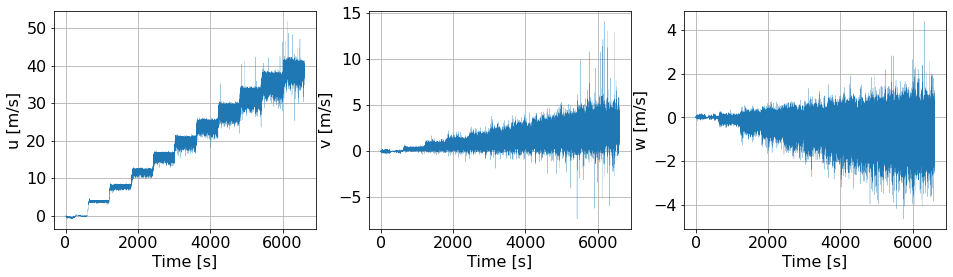

In [5]:
plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(ds.time, ds.u, lw=0.2)
ax2.plot(ds.time, ds.v, lw=0.2)
ax3.plot(ds.time, ds.w, lw=0.2)
ax1.set_ylabel('u [m/s]')
ax2.set_ylabel('v [m/s]')
ax3.set_ylabel('w [m/s]')
for ax in [ax1, ax2, ax3]:
    ax.grid()
    ax.set_xlabel('Time [s]')

In [6]:
def eddy_covariance_flux(ds, t0, t1):
    """Eddy covariance flux from IRGASON, for a time subset between t0 and t1."""
    time = np.array(ds.time)
    mask = (time >= t0) & (time <= t1)
    u, v, w = ds.u[mask][:], ds.v[mask][:], ds.w[mask][:]
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U, W = np.nanmean(u), np.nanmean(w) # time mean
    up, wp = u - U, w - W # deviations from the mean
    uw = np.nanmean(up * wp) # stress
    good = ~np.isnan(u) & ~np.isnan(w)
    perc_good = (u[good].size / u.size) * 100 # percentage of data that is not bad
    return U, uw, perc_good

In [7]:
U = np.zeros(num_runs)
uw = np.zeros(num_runs)
perc_good = np.zeros(num_runs)
for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    U[n], uw[n], perc_good[n] = eddy_covariance_flux(ds, t0, t1)

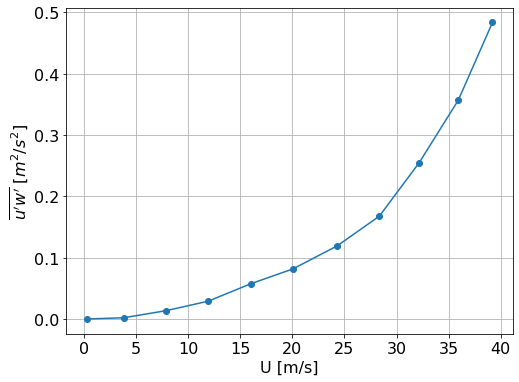

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(U, uw, marker='o')
plt.xlabel('U [m/s]')
plt.ylabel(r"$\overline{u'w'}$ [$m^2/s^2$]")
plt.grid()

## Along-tank pressure gradient

Text(0, 0.5, 'Pressure [Pa]')

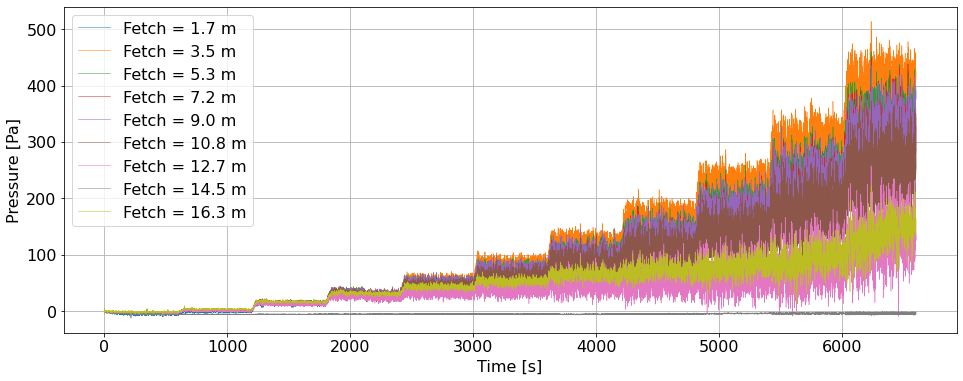

In [9]:
plt.figure(figsize=(16, 6))
for n, x in enumerate(ds.fetch_p):
    plt.plot(ds.time_p, ds.p[n,:], lw=0.5, label='Fetch = %.1f m' % x)
plt.legend()
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')

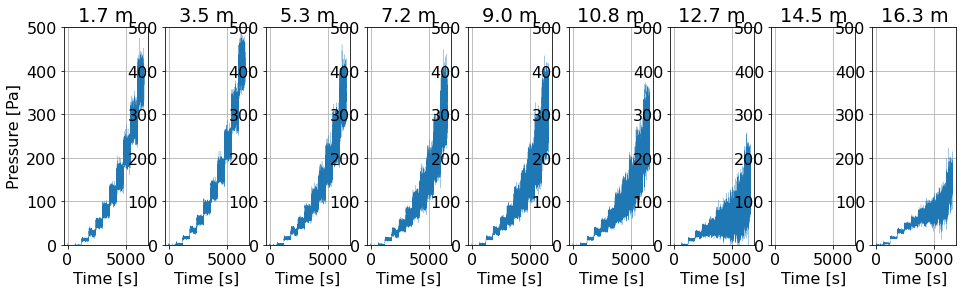

In [10]:
fig = plt.figure(figsize=(16, 4))
for n in range(9):
    ax = plt.subplot2grid((1, 9), (0, n))
    ax.plot(ds.time_p, ds.p[n,:], lw=0.2)
    plt.title('%.1f m' % ds.fetch_p[n])
    plt.grid(True)
    plt.ylim(0, 500)
    if n == 0: plt.ylabel('Pressure [Pa]')
    plt.xlabel('Time [s]')

## Time-average pressure by run

In [11]:
def mean_pressure(p, time, fan, run_seconds, offset):
    pmean = np.zeros((len(fan), p.shape[0]))
    pstd = np.zeros((len(fan), p.shape[0]))
    for n in range(len(fan)):
        t0 = n * run_seconds + offset
        t1 = t0 + run_seconds - offset
        mask = (time >= t0) & (time < t1)
        for i in range(p.shape[0]):
            pp = p[i,mask]
            pmean[n,i] = np.mean(pp)
            pstd[n,i] = np.std(pp)
    return pmean, pstd

In [12]:
pmean, pstd = mean_pressure(np.array(ds.p), np.array(ds.time_p), fan, run_seconds, offset)

In [13]:
# there was an issue with this port and it didn't record; mask it out
pmean[:,7] = np.nan
pstd[:,7] = np.nan

### Mean pressure by fetch and fan speed 

Text(0, 0.5, 'Mean pressure [Pa]')

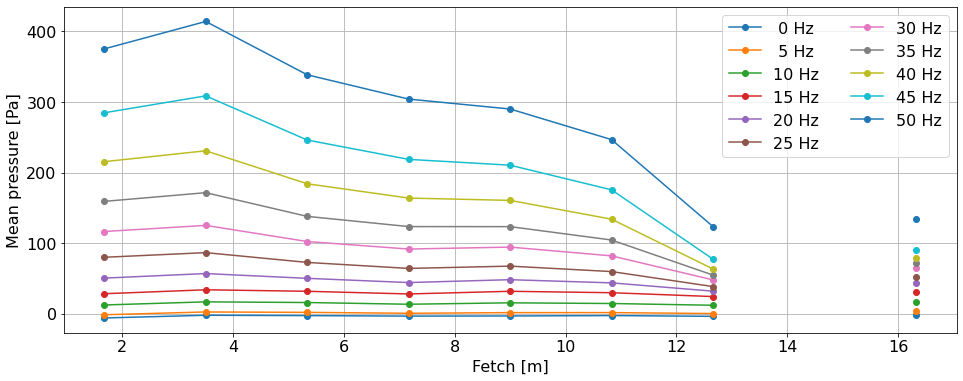

In [14]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_p, pmean[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Mean pressure [Pa]')

### Standard deviation of pressure by fetch and fan speed 

Text(0, 0.5, 'Pressure standard deviation [Pa]')

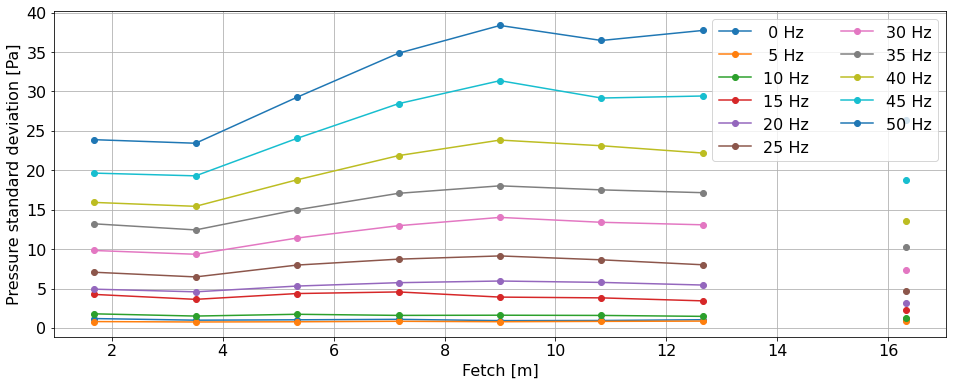

In [15]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_p, pstd[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Pressure standard deviation [Pa]')

Text(0, 0.5, 'Pressure [Pa]')

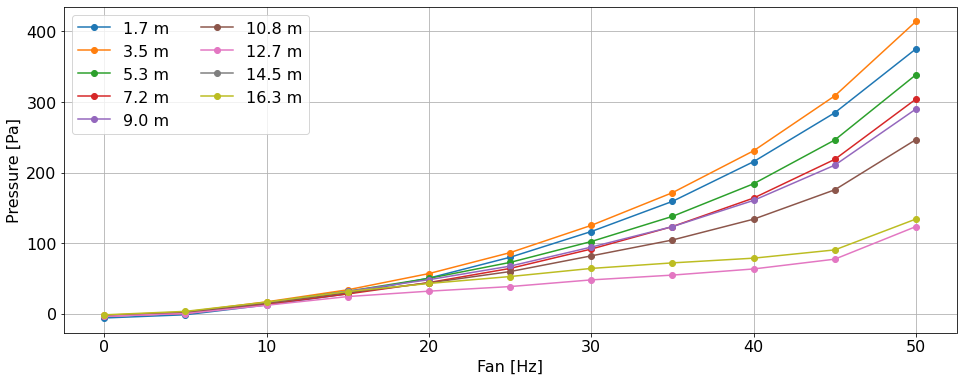

In [16]:
plt.figure(figsize=(16, 6))
for i, x in enumerate(ds.fetch_p):
    plt.plot(fan, pmean[:,i], marker='o', label='%.1f m' % x)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Fan [Hz]')
plt.ylabel('Pressure [Pa]')

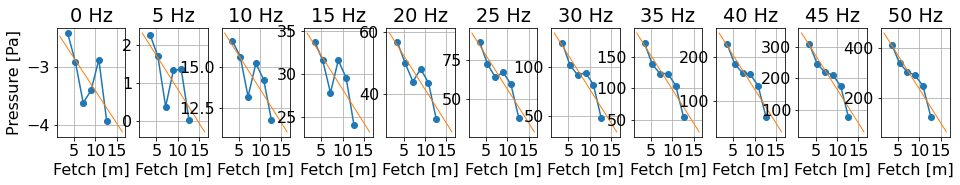

In [17]:
good = [1, 2, 3, 4, 5, 6]

fig = plt.figure(figsize=(16, 2))
dpdx = np.zeros((len(fan)))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    plt.plot(ds.fetch_p[good], pmean[n,good], marker='o')
    p = np.polyfit(ds.fetch_p[good], pmean[n,good], 1)
    dpdx[n] = p[0]
    x = ds.fetch_p
    plt.plot(x, np.polyval(p, x), lw=1)
    plt.xlabel('Fetch [m]')
    if n == 0: plt.ylabel('Pressure [Pa]')
    plt.title(str(fan[n]) + ' Hz')
    plt.grid()

## Along-tank pressure gradient


$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \underline{\mathbf{\dfrac{\partial p}{\partial x}}}
     + \dfrac{\partial S_{xx}}{\partial x}
$$

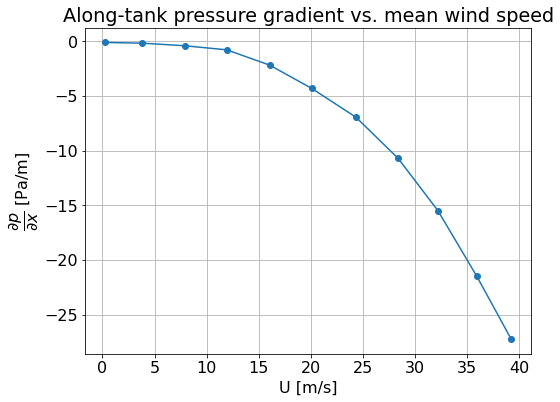

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(U, dpdx, marker='o')
plt.xlabel('U [m/s]')
plt.ylabel(r'$\dfrac{\partial p}{\partial x}$ [Pa/m]')
plt.title('Along-tank pressure gradient vs. mean wind speed')
plt.grid()

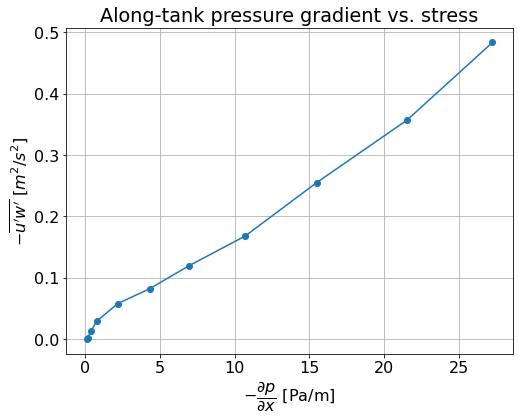

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(-dpdx, uw, marker='o')
plt.xlabel(r'$-\dfrac{\partial p}{\partial x}$ [Pa/m]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.title('Along-tank pressure gradient vs. stress')
plt.grid()

## Mean slope and radiation stress gradient from wave wires

In [20]:
GRAV = 9.8

def cp_cg(F, f, depth):
    """Return phase and group speeds for a wave spectrum."""
    w = 2 * np.pi * f
    k = w2k(w, depth)[0]
    cp = w[1:] / k[1:]
    cg = np.diff(w) / np.diff(k)
    return cp, cg

def radiation_stress(F, f, df, depth, rhow=1000):
    """Returns radiation stress."""
    cp, cg = cp_cg(F, f, depth)
    rad_stress_fac = 2 * cg / cp - 0.5
    return rhow * GRAV * np.sum(rad_stress_fac * F[1:] * df)

def stress_from_momentum_budget(H, dhdx, dSxxdx, dpdx, taub, rhow):
    """Returns the stress estimate from momentum budget components."""
    return rhow * GRAV * H * dhdx + H * dpdx + dSxxdx - taub

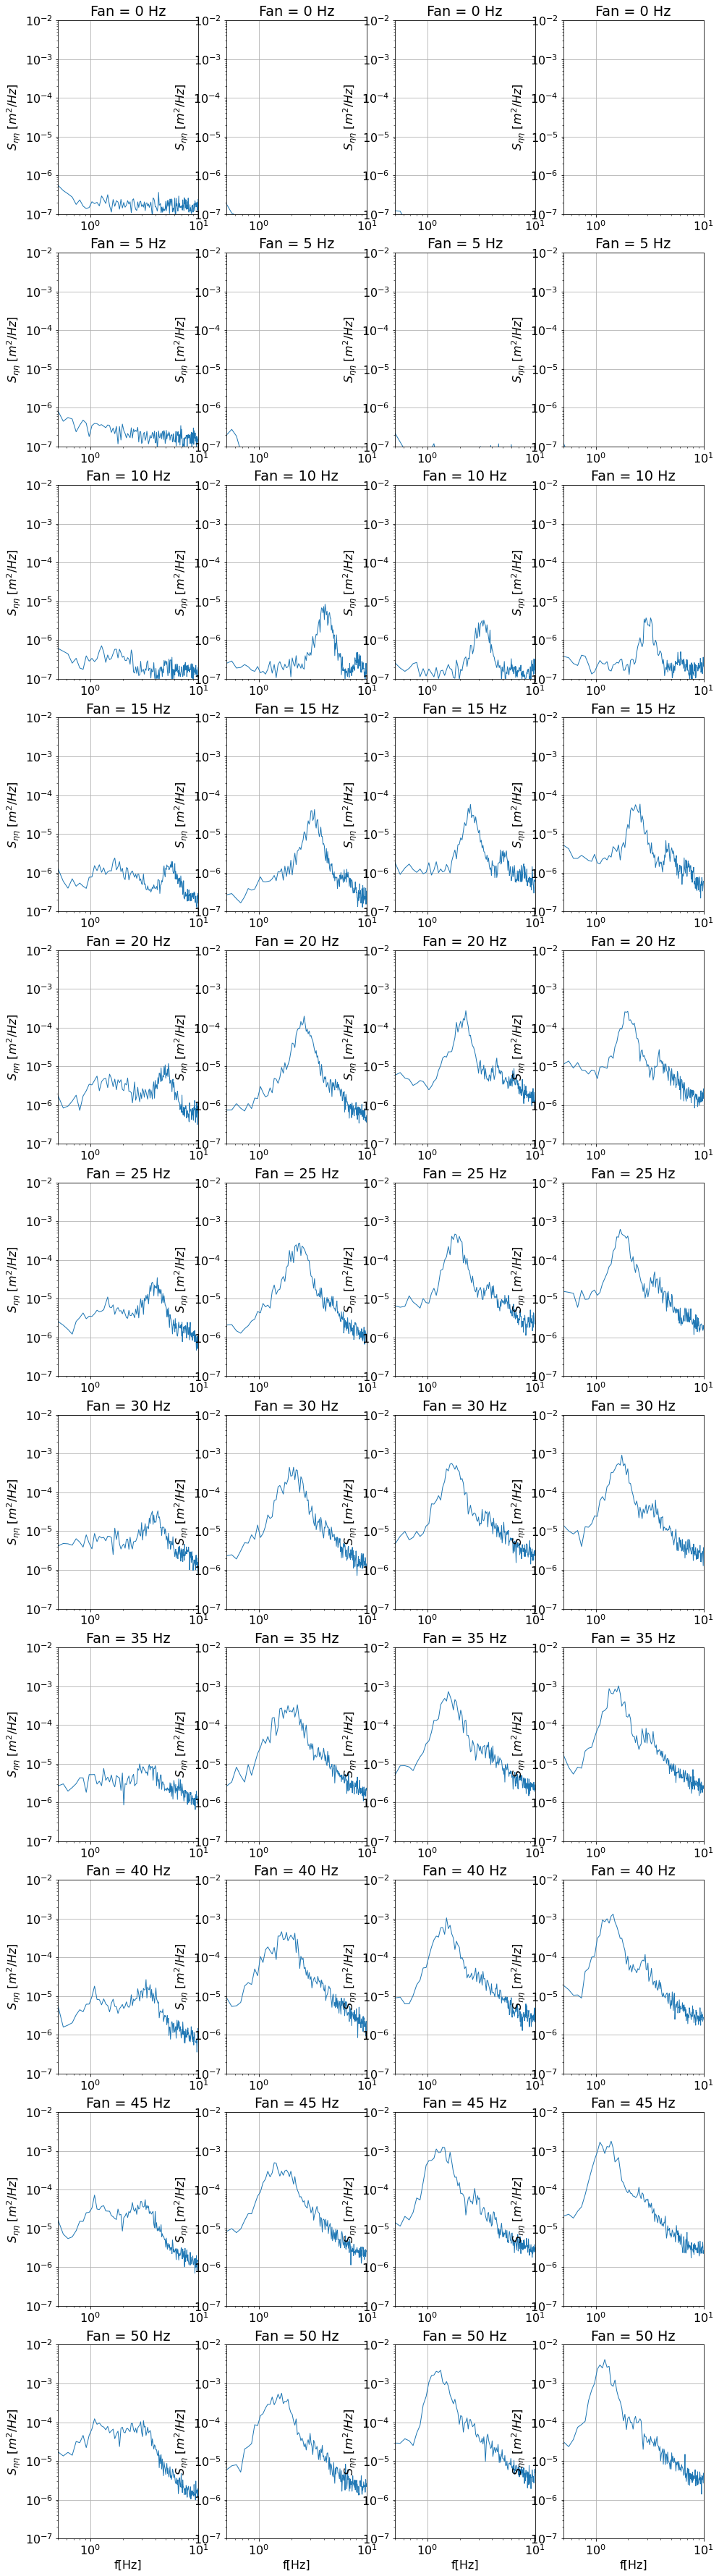

In [21]:
num_wires = ds.fetch_w.shape[0]

fig = plt.figure(figsize=(16, 64))
for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time <= t1)
    for i in range(num_wires):
        ax = plt.subplot2grid((num_runs, num_wires), (n, i))
        e = detrend(ds.eta_w[i,mask])
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        ax.loglog(f, F, lw=1)
        ax.set_xlim(0.5, 1e1)
        ax.set_ylim(1e-7, 1e-2)
        ax.set_title('Fan = %i Hz' % fan[n])
        ax.set_ylabel('$S_{\eta\eta}$ [$m^2/Hz$]')
        ax.grid()
        if n == num_runs - 1: ax.set_xlabel('f[Hz]')

In [22]:
h = np.zeros((num_runs, 4))
Sxx = np.zeros((num_runs, 4))

for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time < t1)
    for i in range(4):
        h[n,i] = np.mean(ds.eta_w[i,mask])
        eta = detrend(ds.eta_w[i,mask])
        F, f, df = power_spectrum(eta, 1 / 20, binsize=1)
        fmask = (f > 0.5) & (f < 10)
        Sxx[n,i] = radiation_stress(F[fmask], f[fmask], np.diff(f)[0], 0.8, rhow=1000)

## Mean water elevation as function of fan speed and fetch

Text(0.5, 1.0, 'Mean elevation from wave wire')

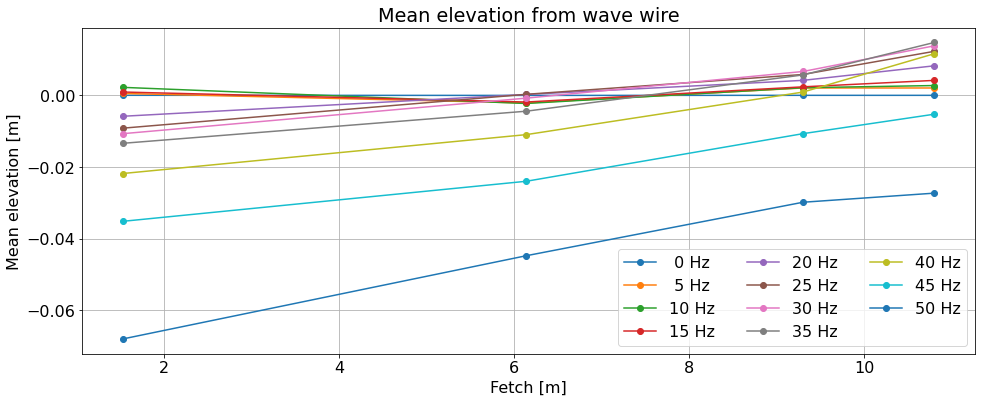

In [23]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_w, h[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=3)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Mean elevation [m]')
plt.title('Mean elevation from wave wire')

Text(0.5, 1.0, 'Mean radiation stress from wave wire')

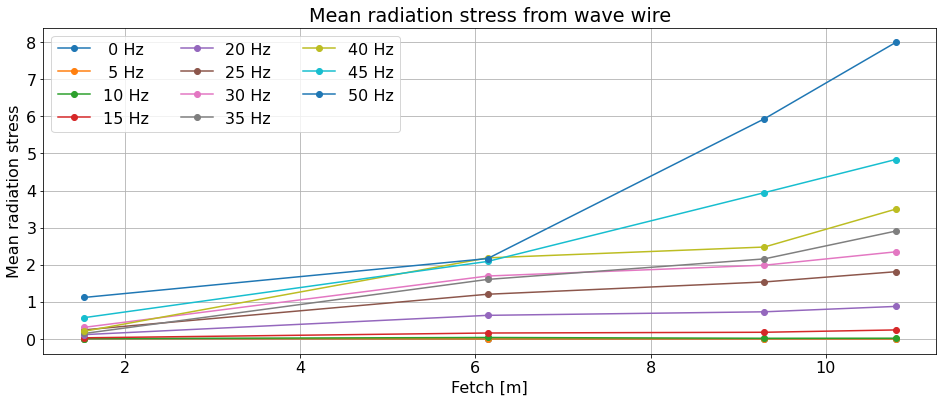

In [24]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_w, Sxx[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=3)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Mean radiation stress')
plt.title('Mean radiation stress from wave wire')

In [25]:
good = [0, 1, 2, 3]
dhdx = np.zeros((num_runs))
dSxxdx = np.zeros((num_runs))
for n in range(num_runs):
    x = ds.fetch_w[good]
    dhdx[n] = np.polyfit(x, h[n,good], 1)[0]
    dSxxdx[n] = np.polyfit(x, Sxx[n,good], 1)[0]

## Mean water elevation slope

$$
\tau = \rho_w g H \underline{\mathbf{\dfrac{\partial h}{\partial x}}} 
     + H \dfrac{\partial p}{\partial x}
     + \dfrac{\partial S_{xx}}{\partial x}
$$

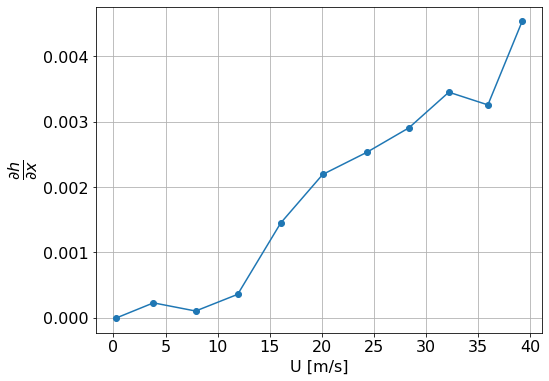

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(U, dhdx, marker='o')
plt.xlabel('U [m/s]')
plt.ylabel(r'$\dfrac{\partial h}{\partial x}$')
plt.grid()

## Radiation stress gradient

$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \dfrac{\partial p}{\partial x}
     + \underline{\mathbf{\dfrac{\partial S_{xx}}{\partial x}}}
$$

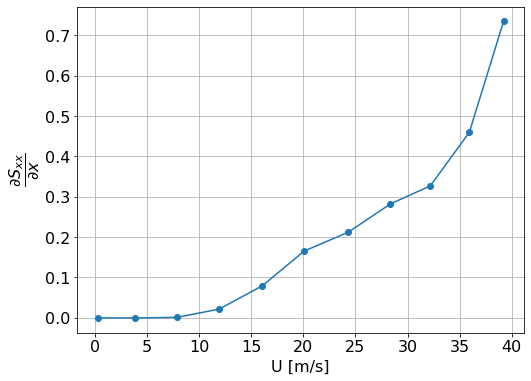

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(U, dSxxdx, marker='o')
plt.xlabel('U [m/s]')
plt.ylabel(r'$\dfrac{\partial S_{xx}}{\partial x}$')
plt.grid()

## Putting the momentum budget components together

$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \dfrac{\partial p}{\partial x}
     + \dfrac{\partial S_{xx}}{\partial x}
     - \tau_B
$$

In [28]:
H = np.mean(h, axis=1) + 0.8
rhow = 1e3
rhoa = 1.2

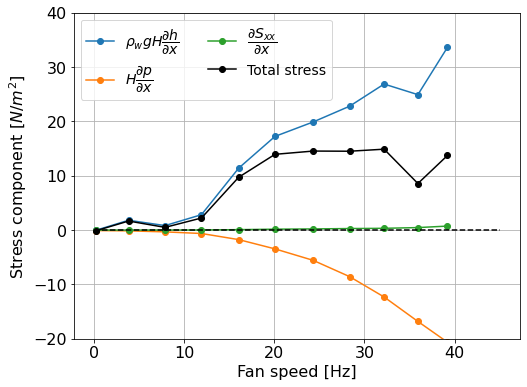

In [29]:
fig = plt.figure(figsize=(8, 6))
plt.plot(U, rhow * GRAV * H * dhdx, marker='o', label=r'$\rho_w g H \dfrac{\partial h}{\partial x}$')
plt.plot(U, H * dpdx, marker='o', label='$H\dfrac{\partial p}{\partial x}$')
plt.plot(U, dSxxdx, marker='o', label='$\dfrac{\partial S_{xx}}{\partial x}$')
plt.plot(U, rhow * GRAV * H * dhdx + H * dpdx + dSxxdx, 'k-', marker='o', label='Total stress')
plt.legend(ncol=2, prop={'size': 14})
plt.xlabel('Fan speed [Hz]')
plt.ylabel('Stress component [$N/m^2$]')
plt.plot([0, 45], [0, 0], 'k--')
plt.ylim(-20, 40)
plt.grid()

In [30]:
tau = rhow * GRAV * H * dhdx + H * dpdx + dSxxdx
ust = np.sqrt(tau / rhoa)

In [31]:
U10 = U + ust / 0.4 * np.log(10 / 0.6)

In [32]:
Cd = (ust / U10)**2

In [33]:
Cd

array([       nan, 0.00943184, 0.00269166, 0.00400764, 0.00622614,
       0.00598608, 0.00508782, 0.0043357 , 0.00382455, 0.00238463,
       0.00288276])

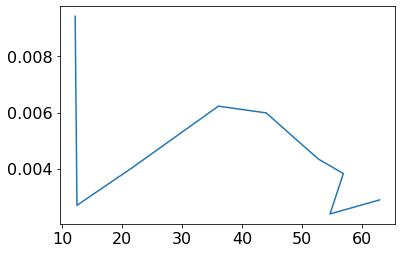

In [34]:
plt.plot(U10, Cd)

## Mean slope and radiation stress gradient from UDM

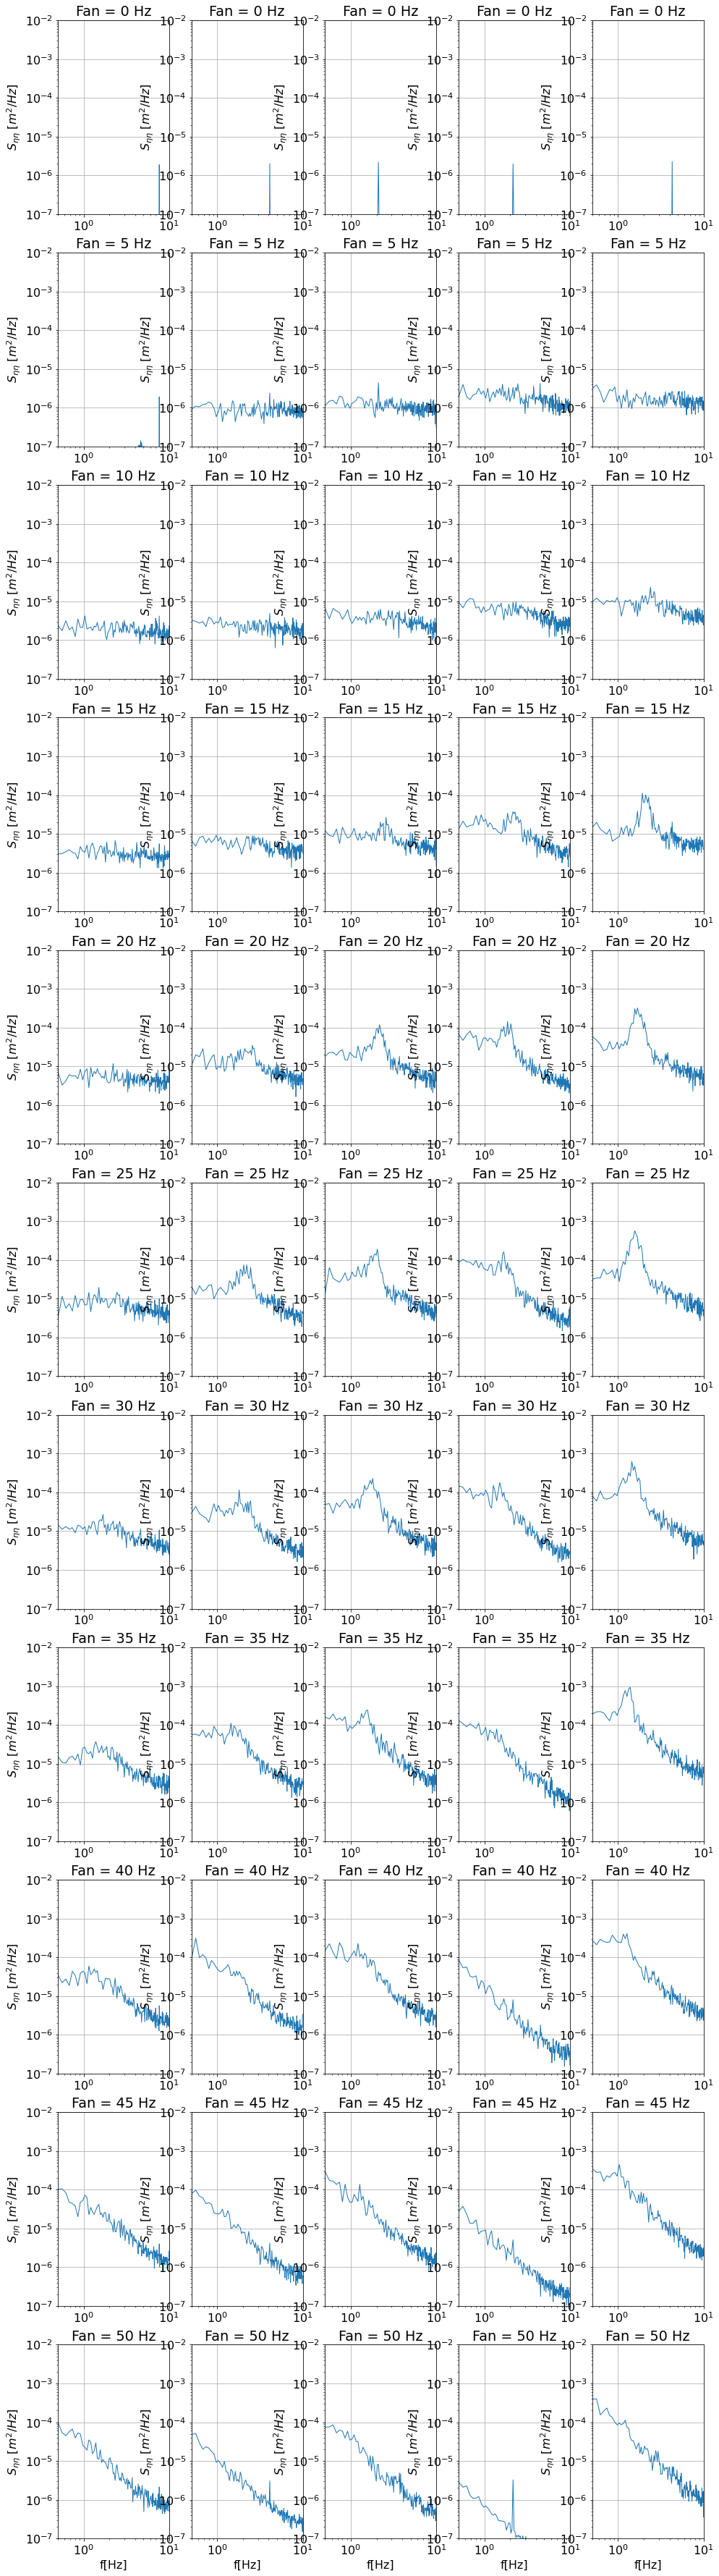

In [35]:
num_sensors = ds.fetch_u.shape[0]

fig = plt.figure(figsize=(16, 64))
for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time <= t1)
    for i in range(num_sensors):
        ax = plt.subplot2grid((num_runs, num_sensors), (n, i))
        e = detrend(ds.eta_u[i,mask])
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        ax.loglog(f, F, lw=1)
        ax.set_xlim(0.5, 1e1)
        ax.set_ylim(1e-7, 1e-2)
        ax.set_title('Fan = %i Hz' % fan[n])
        ax.set_ylabel('$S_{\eta\eta}$ [$m^2/Hz$]')
        ax.grid()
        if n == num_runs - 1: ax.set_xlabel('f[Hz]')

In [36]:
h_udm = np.zeros((num_runs, num_sensors))
for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time < t1)
    for i in range(num_sensors):
        h_udm[n,i] = np.mean(ds.eta_u[i,mask])

Text(0.5, 1.0, 'Mean elevation from wave wire')

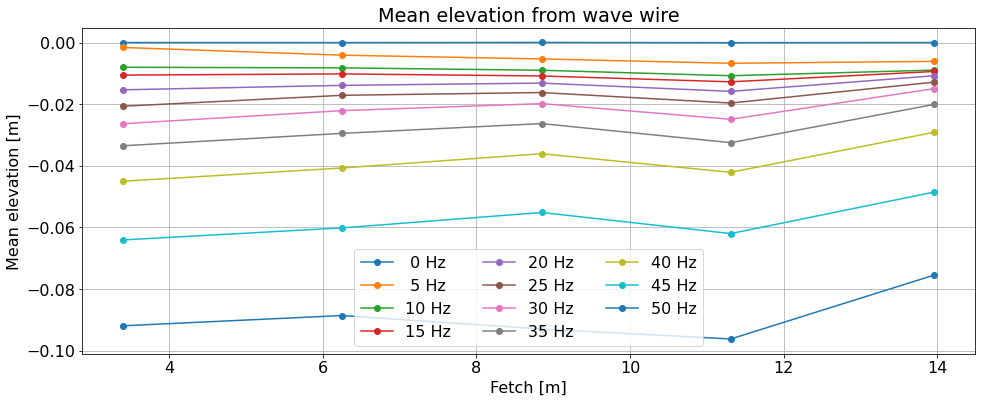

In [37]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_u, h_udm[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=3)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Mean elevation [m]')
plt.title('Mean elevation from wave wire')

In [38]:
good = [0, 1, 2, 3, 4]
dhdx_udm = np.zeros((num_runs))
for n in range(num_runs):
    x = ds.fetch_u[good]
    dhdx_udm[n] = np.polyfit(x, h_udm[n,good], 1)[0]

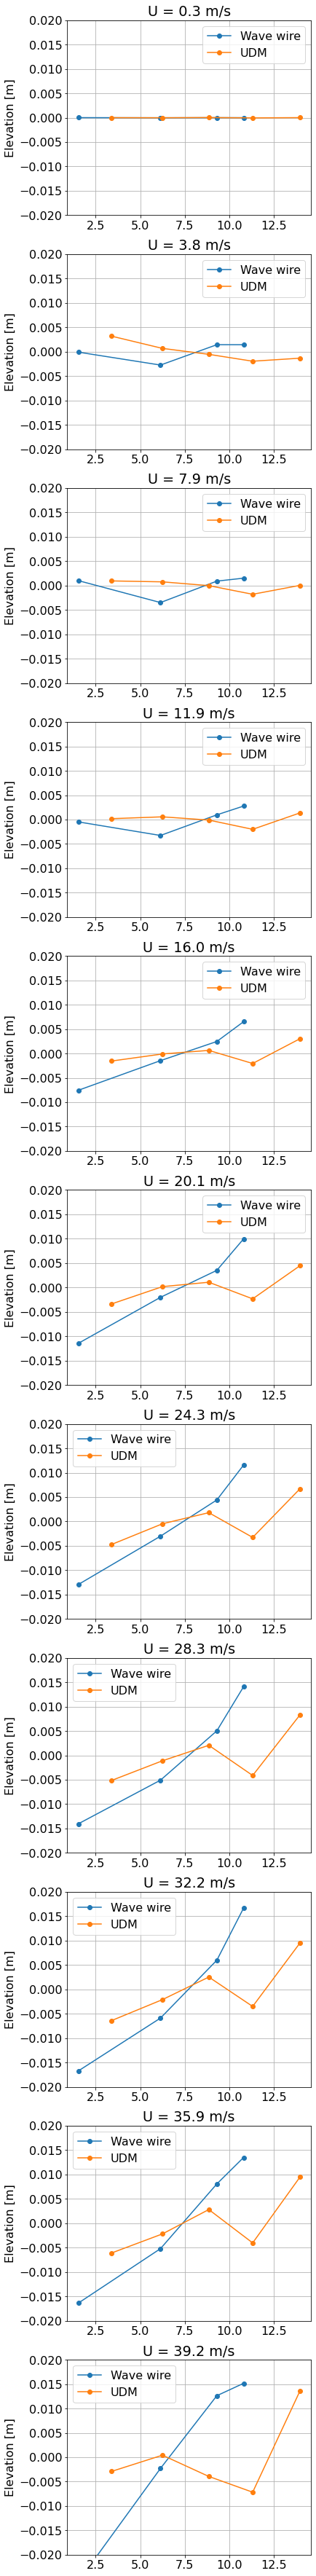

In [39]:
plt.figure(figsize=(6, 64))
for n, f in enumerate(fan):
    ax = plt.subplot2grid((len(fan), 1), (n, 0))
    ax.plot(ds.fetch_w, h[n,:] - np.mean(h[n,:]), marker='o', label='Wave wire')
    ax.plot(ds.fetch_u, h_udm[n,:] - np.mean(h_udm[n,:]), marker='o', label='UDM')
    ax.legend()
    ax.set_ylabel('Elevation [m]')
    ax.set_title('U = %.1f m/s' % U[n])
    ax.grid()
    ax.set_ylim(-0.02, 0.02)